## Kaggle I’m Something of a Painter Myself



Description
“Every artist dips his brush in his own soul, and paints his own nature into his pictures.”
-Henry Ward Beecher

We recognize the works of artists through their unique style, such as color choices or brush strokes. The “je ne sais quoi” of artists like Claude Monet can now be imitated with algorithms thanks to generative adversarial networks (GANs). In this getting started competition, you will bring that style to your photos or recreate the style from scratch!

Computer vision has advanced tremendously in recent years and GANs are now capable of mimicking objects in a very convincing way. But creating museum-worthy masterpieces is thought of to be, well, more art than science. So can (data) science, in the form of GANs, trick classifiers into believing you’ve created a true Monet? That’s the challenge you’ll take on!

The Challenge:
A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

Your task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

Getting Started:
Details on the dataset can be found here and an overview of the evaluation process can be found here.

To learn how to submit and answers to other FAQs, review the Frequently Asked Questions.

Recommended Tutorial
We highly recommend Amy Jang's notebook that goes over the basics of loading data from TFRecords, using TPUs, and building a CycleGAN.
Although the competition dataset only includes Monet images, check out this dataset for Cezanne, Ukiyo-e, and Van Gogh paintings to run your GAN on.

Submission format
Your kernel's output must be called images.zip and contain 7,000-10,000 images sized 256x256. The images should be in .jpg format.


In [1]:
# load the data
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


monet_jpg_dir = './gan-getting-started/monet_jpg'
photo_jpg_dir = './gan-getting-started/photo_jpg'
monet_tfrec_dir = './gan-getting-started/monet_tfrec'
photo_tfrec_dir = './gan-getting-started/photo_tfrec'

monet_jpg = os.listdir(monet_jpg_dir)
photo_jpg = os.listdir(photo_jpg_dir)
monet_tfrec = os.listdir(monet_tfrec_dir)
photo_tfrec = os.listdir(photo_tfrec_dir)

print(f'Number of Monet jpg images: {len(monet_jpg)}')
print(f'Number of Photo jpg images: {len(photo_jpg)}')
print(f'Number of Monet tfrec images: {len(monet_tfrec)}')
print(f'Number of Photo tfrec images: {len(photo_tfrec)}')



Number of Monet jpg images: 300
Number of Photo jpg images: 7038
Number of Monet tfrec images: 5
Number of Photo tfrec images: 20


2024-06-21 10:10:22.929727: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-06-21 10:10:22.929748: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-06-21 10:10:22.929752: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-06-21 10:10:22.929786: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-21 10:10:22.929799: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


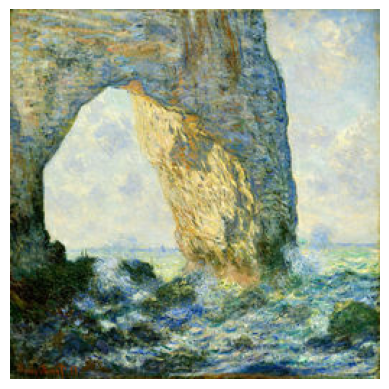

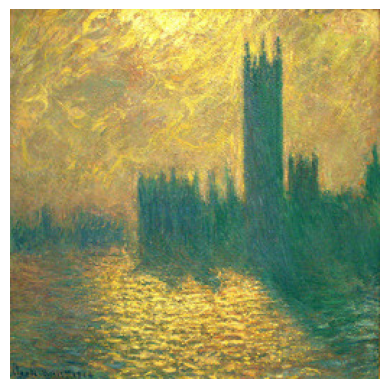

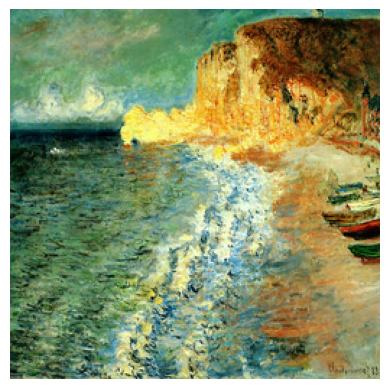

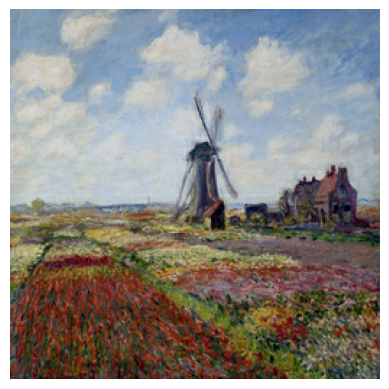

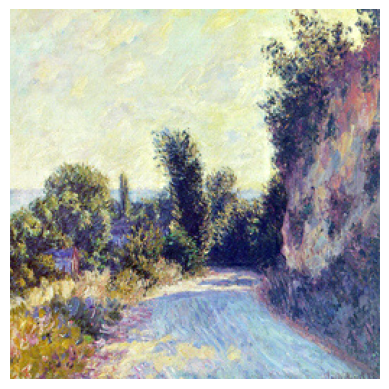

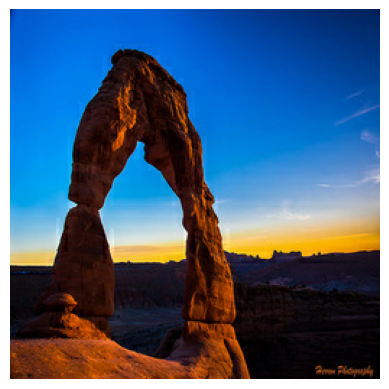

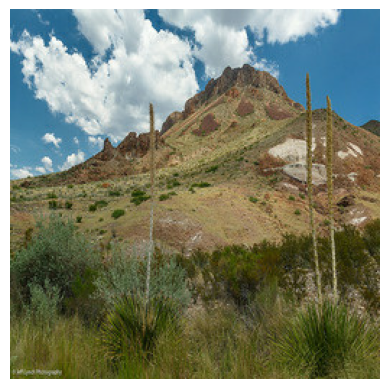

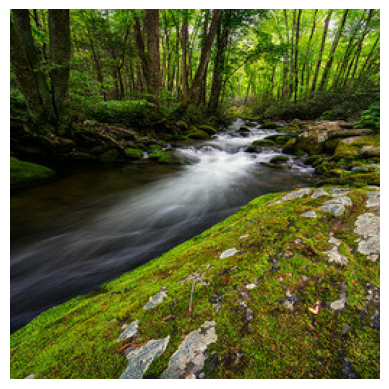

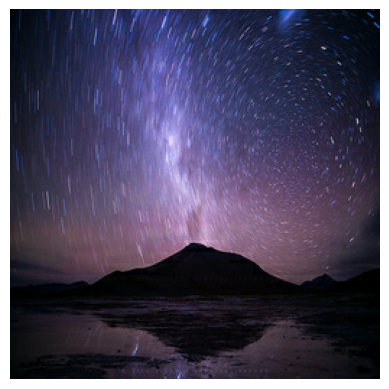

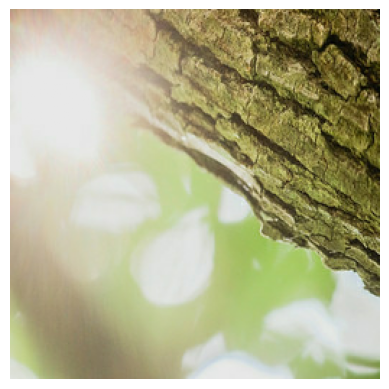

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf

def parse_tfrecord(tfrecord):
    features = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(tfrecord, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (image - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

# Load and visualize the datasets
monet_files = tf.io.gfile.glob('./gan-getting-started/monet_tfrec/*.tfrec')
photo_files = tf.io.gfile.glob('./gan-getting-started/photo_tfrec/*.tfrec')

monet_ds = load_dataset(monet_files)
photo_ds = load_dataset(photo_files)

def visualize_dataset(dataset, num_images):
    for image_batch in dataset.take(num_images):
        image = image_batch.numpy()
        plt.imshow((image + 1) / 2)  # Denormalize and display the image
        plt.axis('off')
        plt.show()

# Visualize examples from Monet and Photo datasets
visualize_dataset(monet_ds, 5)
visualize_dataset(photo_ds, 5)



### Load the datasets
We will load the Monet and Photo datasets using the `load_dataset` function. The datasets are stored in TFRecord format, and we will parse the TFRecord files to extract the images.


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics, callbacks
import matplotlib.pyplot as plt

monet_tfrec_dir = './gan-getting-started/monet_tfrec'
photo_tfrec_dir = './gan-getting-started/photo_tfrec'

def parse_tfrecord(tfrecord):
    features = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(tfrecord, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (image - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

monet_files = tf.io.gfile.glob(monet_tfrec_dir + '/*.tfrec')
photo_files = tf.io.gfile.glob(photo_tfrec_dir + '/*.tfrec')

monet_ds = load_dataset(monet_files)
photo_ds = load_dataset(photo_files)


### Prepare the dataset
We will prepare the dataset by shuffling, batching, and prefetching the data. The dataset will be zipped together to combine the Monet and Photo images.



In [4]:
def prepare_dataset(monet_ds, photo_ds, batch_size=4):
    monet_ds = monet_ds.shuffle(buffer_size=1024).batch(batch_size)
    photo_ds = photo_ds.shuffle(buffer_size=1024).batch(batch_size)
    dataset = tf.data.Dataset.zip((monet_ds, photo_ds))
    dataset = dataset.repeat()  # Repeat the dataset indefinitely
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

batch_size = 4
train_dataset = prepare_dataset(monet_ds, photo_ds, batch_size=batch_size)


### Define the model
We will define the generator and discriminator models for the CycleGAN. The generator model will convert the input images to the target domain, while the discriminator model will classify the real and generated images.

In [5]:
monet_steps = len(monet_files) // batch_size
photo_steps = len(photo_files) // batch_size
steps_per_epoch = max(monet_steps, photo_steps)


In [6]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.keras.initializers.GlorotNormal()
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result


In [7]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.keras.initializers.GlorotNormal()
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result


In [8]:
def residual_block(x, filters, size):
    initializer = tf.keras.initializers.GlorotNormal()
    y = layers.Conv2D(filters, size, strides=1, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)
    y = layers.Conv2D(filters, size, strides=1, padding='same', kernel_initializer=initializer, use_bias=False)(y)
    y = layers.BatchNormalization()(y)
    y = layers.Add()([x, y])
    return y


### Define the generator and discriminator models
We will define the generator and discriminator models using the `downsample`, `upsample`, and `residual_block` functions.

The generator model will convert the input images to the target domain, while the discriminator model will classify the real and generated images.



In [9]:
def Generator():
    inputs = layers.Input(shape=[256, 256, 3])
    down_stack = [
        downsample(64, 4, apply_norm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    initializer = tf.keras.initializers.GlorotNormal()
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')
    x = inputs
    skips = []

    for down in down_stack:
        x = down(x)
        skips.append(x)

    for _ in range(6):  # Number of residual blocks
        x = residual_block(x, 512, 3)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return models.Model(inputs=inputs, outputs=x)


### Discriminator model
The discriminator model will classify the real and generated images. It will take the input images and concatenate them together before passing them through the convolutional layers.


In [10]:
def Discriminator():
    initializer = tf.keras.initializers.GlorotNormal()
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    tar = layers.Input(shape=[256, 256, 3], name='target_image')
    x = layers.concatenate([inp, tar])
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
    return models.Model(inputs=[inp, tar], outputs=last)


### Define the CycleGAN model

The CycleGAN model will consist of two generators (Monet and Photo) and two discriminators (Monet and Photo). We will define the CycleGAN model using the `CycleGAN` class. The model will compile the generators and discriminators with the respective optimizers and loss functions.


In [11]:
class CycleGAN(models.Model):
    def __init__(self, monet_gen, photo_gen, monet_disc, photo_disc, lambda_cycle=10):
        super(CycleGAN, self).__init__()
        self.monet_gen = monet_gen
        self.photo_gen = photo_gen
        self.monet_disc = monet_disc
        self.photo_disc = photo_disc
        self.lambda_cycle = lambda_cycle

    def compile(self, monet_gen_optimizer, photo_gen_optimizer, monet_disc_optimizer, photo_disc_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn):
        super(CycleGAN, self).compile()
        self.monet_gen_optimizer = monet_gen_optimizer
        self.photo_gen_optimizer = photo_gen_optimizer
        self.monet_disc_optimizer = monet_disc_optimizer
        self.photo_disc_optimizer = photo_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.monet_gen(real_photo, training=True)
            cycled_photo = self.photo_gen(fake_monet, training=True)
            fake_photo = self.photo_gen(real_monet, training=True)
            cycled_monet = self.monet_gen(fake_photo, training=True)

            same_monet = self.monet_gen(real_monet, training=True)
            same_photo = self.photo_gen(real_photo, training=True)

            disc_real_monet = self.monet_disc([real_monet, real_photo], training=True)
            disc_real_photo = self.photo_disc([real_photo, real_monet], training=True)

            disc_fake_monet = self.monet_disc([fake_monet, real_photo], training=True)
            disc_fake_photo = self.photo_disc([fake_photo, real_monet], training=True)

            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet) + self.cycle_loss_fn(real_photo, cycled_photo)

            total_monet_gen_loss = monet_gen_loss + total_cycle_loss * self.lambda_cycle + self.cycle_loss_fn(real_monet, same_monet)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss * self.lambda_cycle + self.cycle_loss_fn(real_photo, same_photo)

            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        monet_gen_grads = tape.gradient(total_monet_gen_loss, self.monet_gen.trainable_variables)
        photo_gen_grads = tape.gradient(total_photo_gen_loss, self.photo_gen.trainable_variables)
        monet_disc_grads = tape.gradient(monet_disc_loss, self.monet_disc.trainable_variables)
        photo_disc_grads = tape.gradient(photo_disc_loss, self.photo_disc.trainable_variables)

        self.monet_gen_optimizer.apply_gradients(zip(monet_gen_grads, self.monet_gen.trainable_variables))
        self.photo_gen_optimizer.apply_gradients(zip(photo_gen_grads, self.photo_gen.trainable_variables))
        self.monet_disc_optimizer.apply_gradients(zip(monet_disc_grads, self.monet_disc.trainable_variables))
        self.photo_disc_optimizer.apply_gradients(zip(photo_disc_grads, self.photo_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss,
        }


### Define the loss functions

We will define the loss functions for the generator and discriminator models. The generator loss function will be the mean squared error, while the discriminator loss function will be the mean squared error of the real and fake images.

In [12]:
def generator_loss_fn(fake):
    return losses.MeanSquaredError()(tf.ones_like(fake), fake)

def discriminator_loss_fn(real, fake):
    real_loss = losses.MeanSquaredError()(tf.ones_like(real), real)
    fake_loss = losses.MeanSquaredError()(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

def cycle_loss_fn(real, cycled):
    return tf.reduce_mean(tf.abs(real - cycled))


In [13]:
monet_gen_optimizer = optimizers.legacy.Adam(2e-4, beta_1=0.5)
photo_gen_optimizer = optimizers.legacy.Adam(2e-4, beta_1=0.5)
monet_disc_optimizer = optimizers.legacy.Adam(2e-4, beta_1=0.5)
photo_disc_optimizer = optimizers.legacy.Adam(2e-4, beta_1=0.5)


In [14]:
monet_generator = Generator()
photo_generator = Generator()
monet_discriminator = Discriminator()
photo_discriminator = Discriminator()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [15]:
cycle_gan_model = CycleGAN(monet_generator, photo_generator, monet_discriminator, photo_discriminator)
cycle_gan_model.compile(
    monet_gen_optimizer=monet_gen_optimizer,
    photo_gen_optimizer=photo_gen_optimizer,
    monet_disc_optimizer=monet_disc_optimizer,
    photo_disc_optimizer=photo_disc_optimizer,
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
    cycle_loss_fn=cycle_loss_fn
)


### Early stopping and learning rate reduction

We will use the early stopping and learning rate reduction callbacks to prevent overfitting and improve the model performance.

In [16]:
early_stopping = callbacks.EarlyStopping(
    monitor='monet_gen_loss',
    patience=15,
    mode='min',
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='monet_gen_loss',
    factor=0.2,
    patience=10,
    mode='min',
    min_lr=1e-8
)


### Train the CycleGAN model

We will train the CycleGAN model using the `fit` method. We will train the model for 100 epochs and use the early stopping and learning rate reduction callbacks.

In [17]:
history = cycle_gan_model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100


2024-06-21 10:10:30.299698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 14s 637ms/step - monet_gen_loss: 15.3337 - photo_gen_loss: 15.8745 - monet_disc_loss: 5.7265 - photo_disc_loss: 5.9920 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 3s 593ms/step - monet_gen_loss: 9.2735 - photo_gen_loss: 9.3245 - monet_disc_loss: 0.8201 - photo_disc_loss: 0.8390 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 3s 586ms/step - monet_gen_loss: 7.7200 - photo_gen_loss: 7.8028 - monet_disc_loss: 0.5382 - photo_disc_loss: 0.5170 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 3s 525ms/step - monet_gen_loss: 7.6095 - photo_gen_loss: 7.6746 - monet_disc_loss: 0.5497 - photo_disc_loss: 0.4462 - lr: 0.0010
Epoch 5/100
5/5 [==============================] - 3s 536ms/step - monet_gen_loss: 6.6060 - photo_gen_loss: 6.8449 - monet_disc_loss: 0.4039 - photo_disc_loss: 0.5277 - lr: 0.0010
Epoch 6/100
5/5 [==============================] - 3s 606ms/step - monet_gen_loss: 6.2491 - photo_gen_loss: 6

### Plot the training history

We will plot the training history of the CycleGAN model to visualize the generator and discriminator losses.

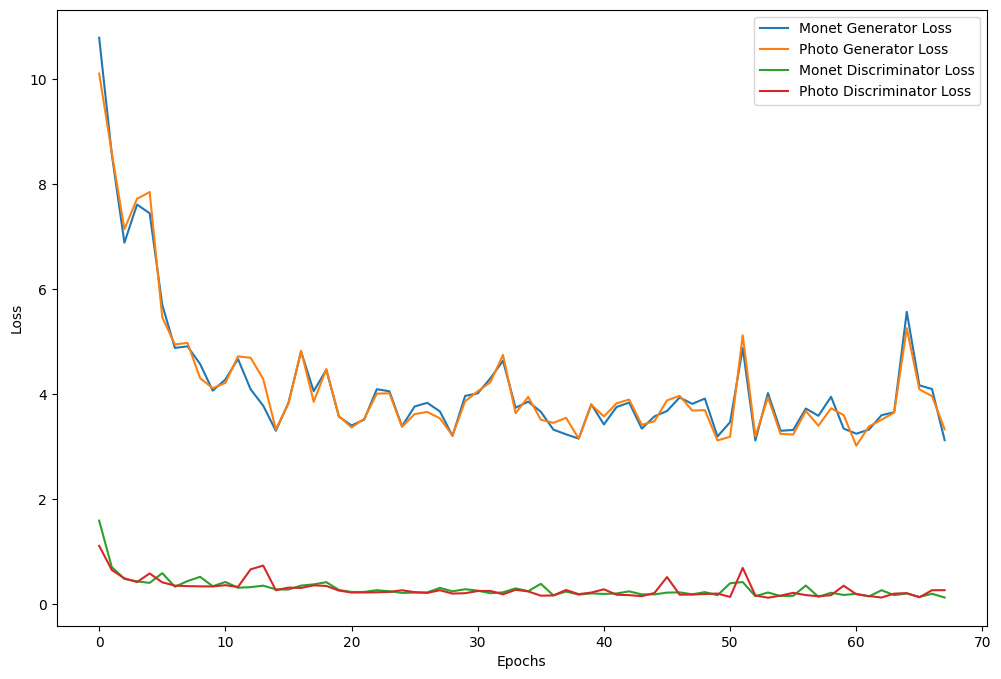

In [18]:
# Print the history of the training
history_df = pd.DataFrame(history.history)
history_df

# Plot the training history
plt.figure(figsize=(12, 8))
plt.plot(history_df['monet_gen_loss'], label='Monet Generator Loss')
plt.plot(history_df['photo_gen_loss'], label='Photo Generator Loss')
plt.plot(history_df['monet_disc_loss'], label='Monet Discriminator Loss')
plt.plot(history_df['photo_disc_loss'], label='Photo Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Generate Monet-style images

We will generate Monet-style images from the photos using the trained generator model. 


In [19]:
import os
import zipfile

def generate_and_save_images(generator, dataset, num_images, output_dir='generated_images'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for i, photo in enumerate(dataset.take(num_images)):
        generated_image = generator(photo, training=False)[0].numpy()
        generated_image = (generated_image * 127.5 + 127.5).astype('uint8')  # Convert to [0, 255] range
        
        output_path = os.path.join(output_dir, f'generated_image_{i+1}.jpg')
        plt.imsave(output_path, generated_image)
    
    return output_dir


In [20]:
def create_zip_file(directory, output_zip='images.zip'):
    with zipfile.ZipFile(output_zip, 'w') as zipf:
        for root, _, files in os.walk(directory):
            for file in files:
                zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), directory))

# Load the dataset of photos
photo_dataset = load_dataset(photo_files).batch(1)

# Generate and save 100 Monet-style images from the photos
output_dir = generate_and_save_images(monet_generator, photo_dataset, num_images=100)

# Create a zip file with the generated images
create_zip_file(output_dir, output_zip='images.zip')


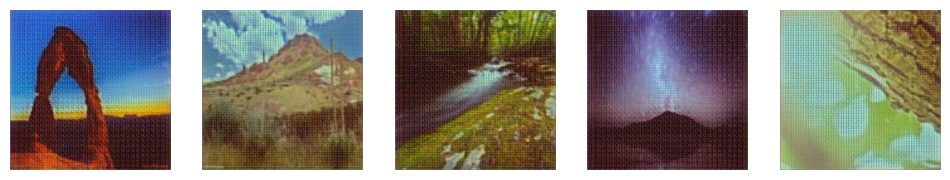

In [21]:
# Display some of the generated images
plt.figure(figsize=(12, 8))
for i in range(5):
    image = plt.imread(f'{output_dir}/generated_image_{i+1}.jpg')
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.axis('off')
    
plt.show()
